In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions_GP_Analysis import test_train_split
from bo_functions_GP_Analysis import bo_iter_w_runs
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 1
train_iter = 300
noise_std = 0.1
runs = 20
explore_bias = torch.tensor([0.75])
shuffle_seed = 6
set_lengthscale = None
# t= 20
emulator = True
sparse_grid = True
verbose = True
save_fig=False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  26-Jul-2022 (15:40:53)


Runs: 20
BO Iters: 1
------------------------------
Lengthscale Set To: None
Explore Bias: 0.75
Run Number:  1


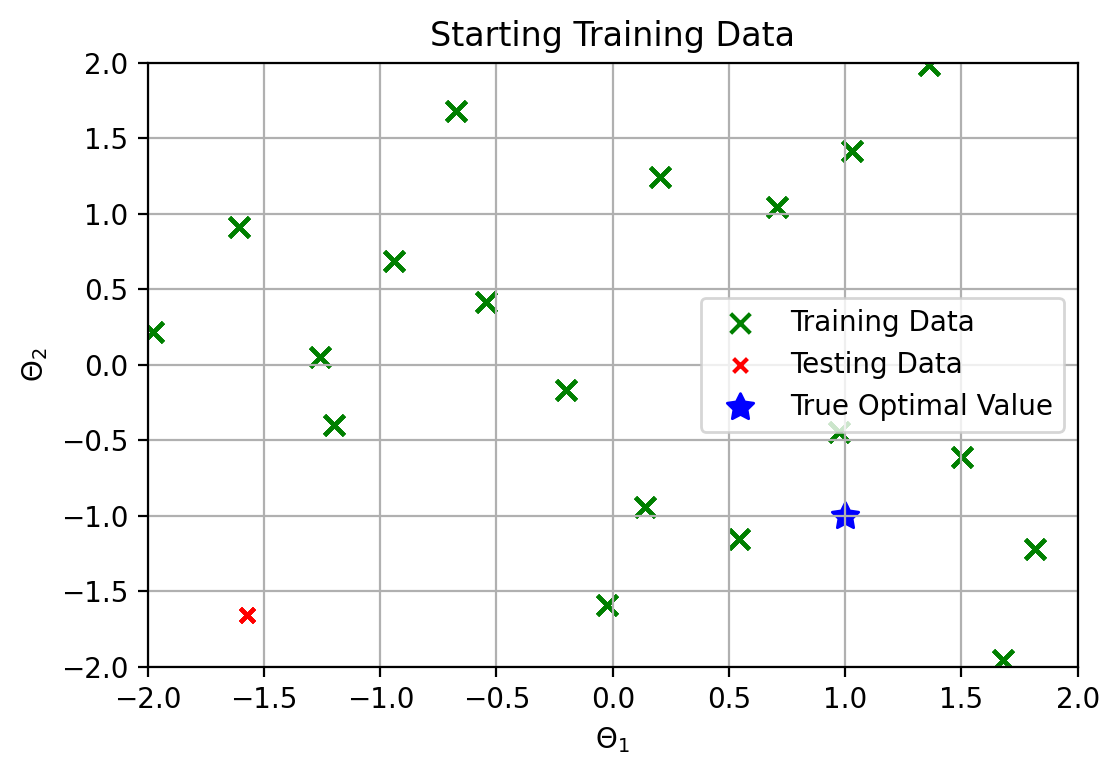

BO Iteration =  1


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Showing X/Y Plot for Theta =  [-1.57404984 -1.65736344] with Xexp = [-2. -1.  0.  1.  2.]


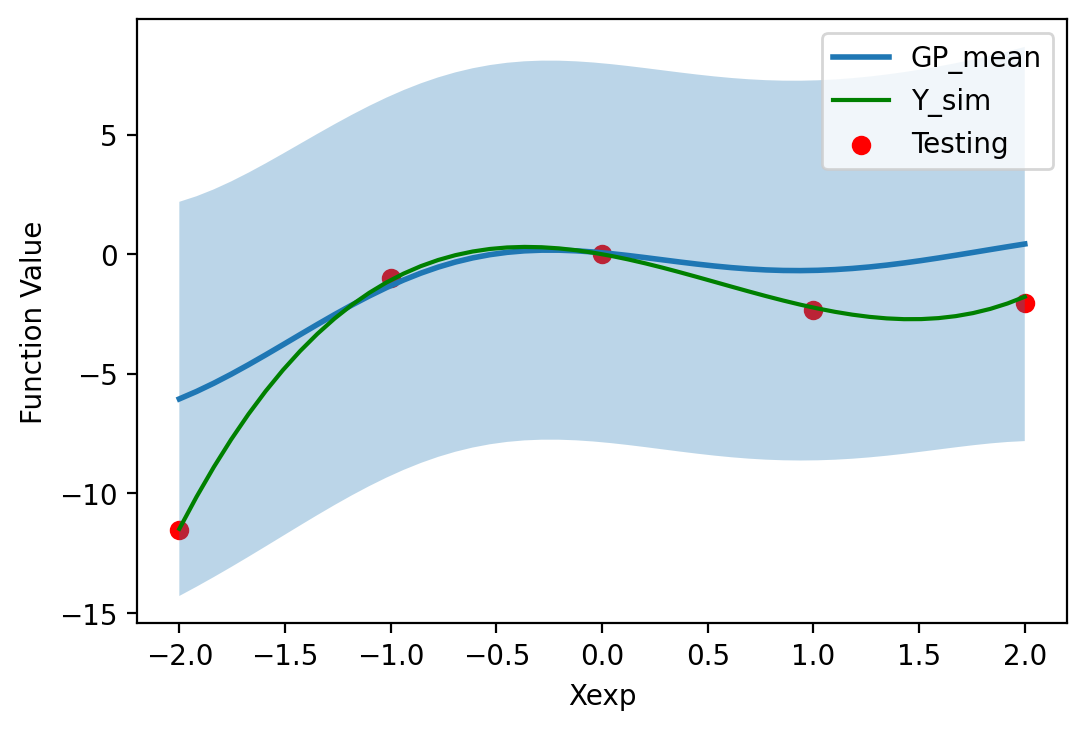

Run Number:  2


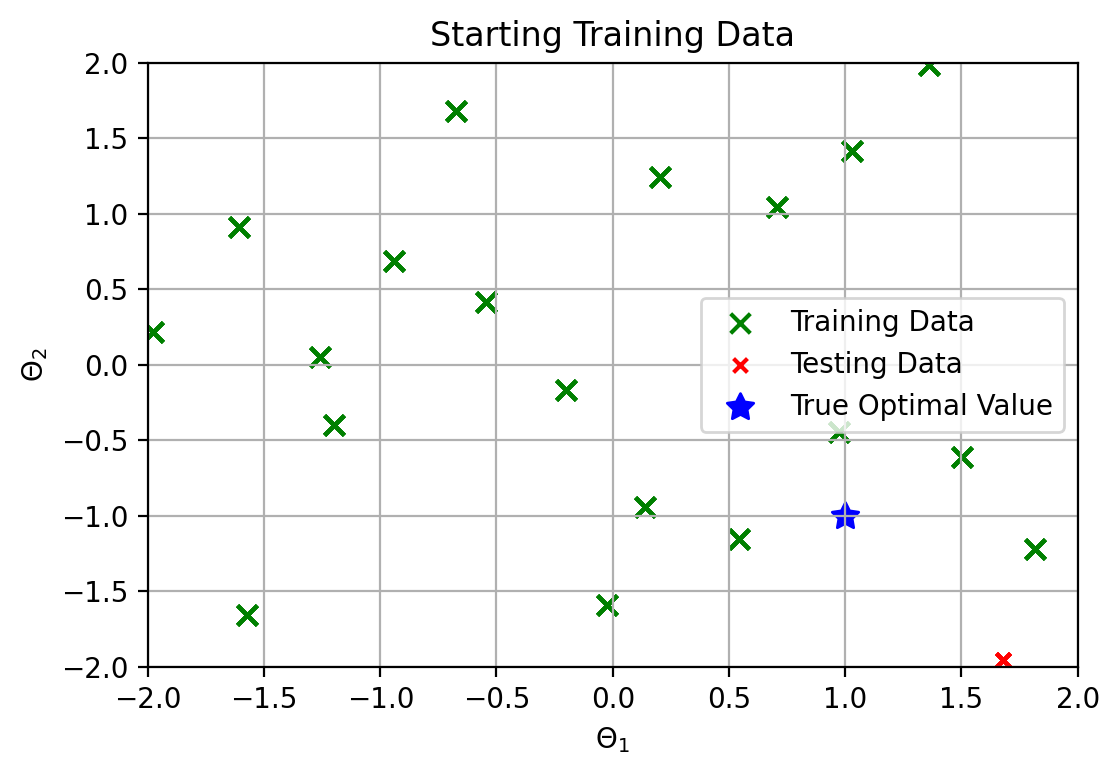

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 1.67937037 -1.95550682] with Xexp = [-2. -1.  0.  1.  2.]


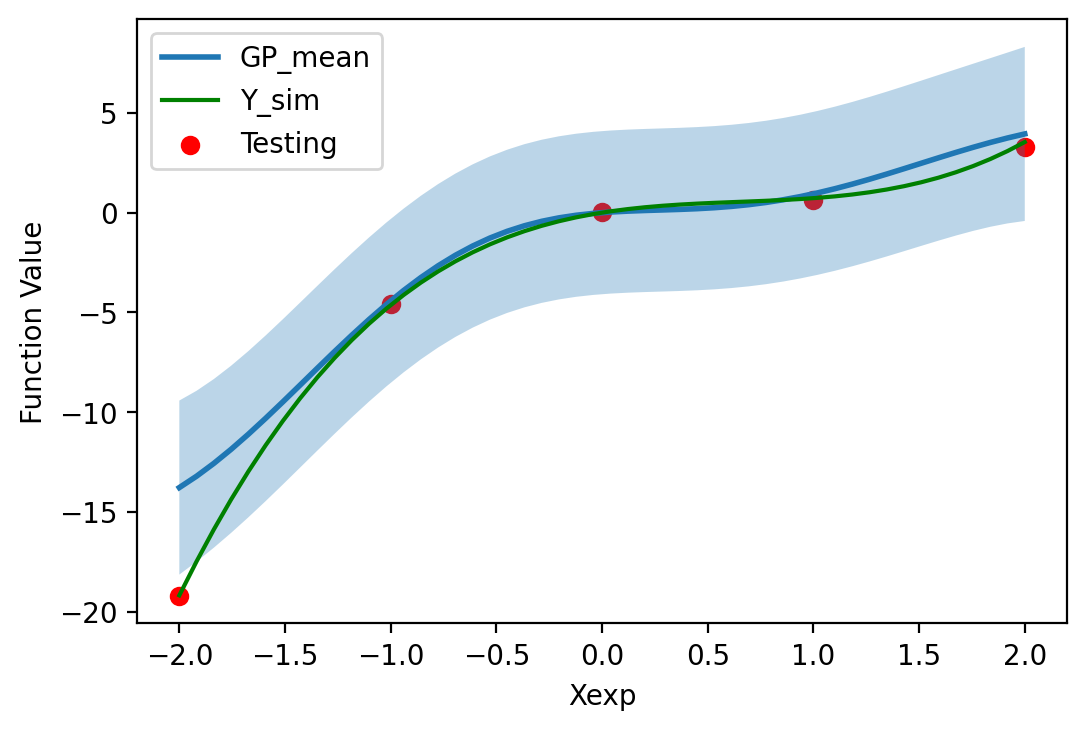

Run Number:  3


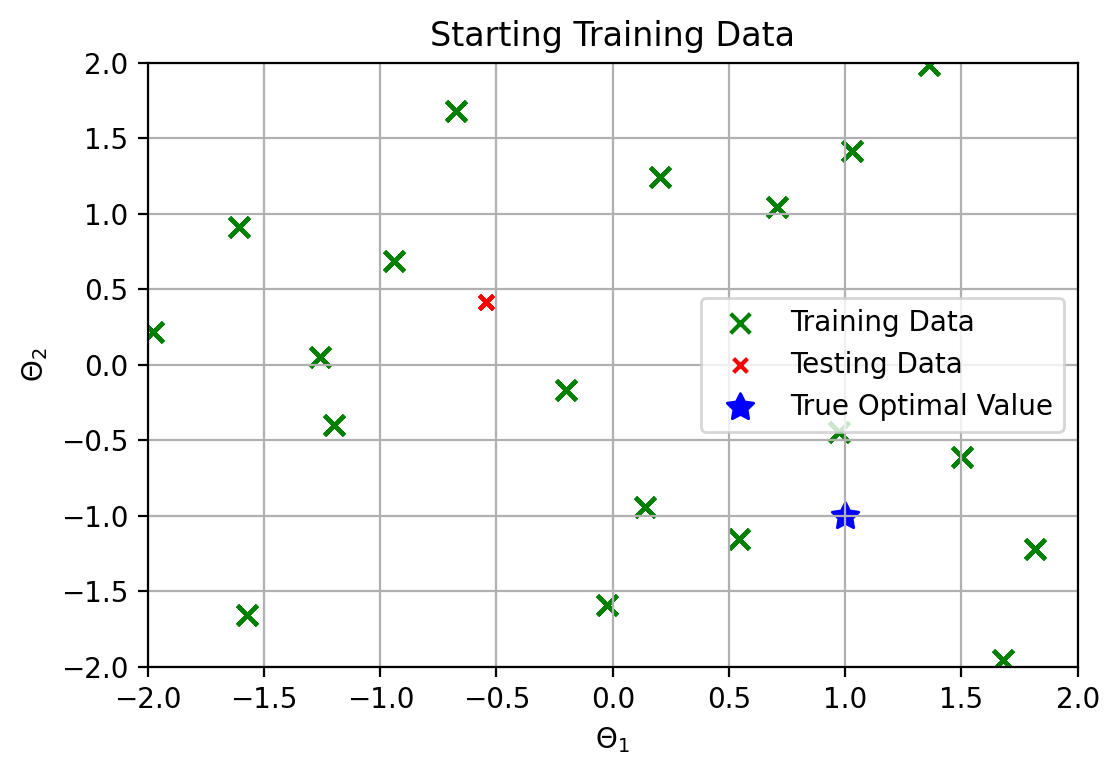

BO Iteration =  1
Showing X/Y Plot for Theta =  [-0.54321493  0.41692398] with Xexp = [-2. -1.  0.  1.  2.]


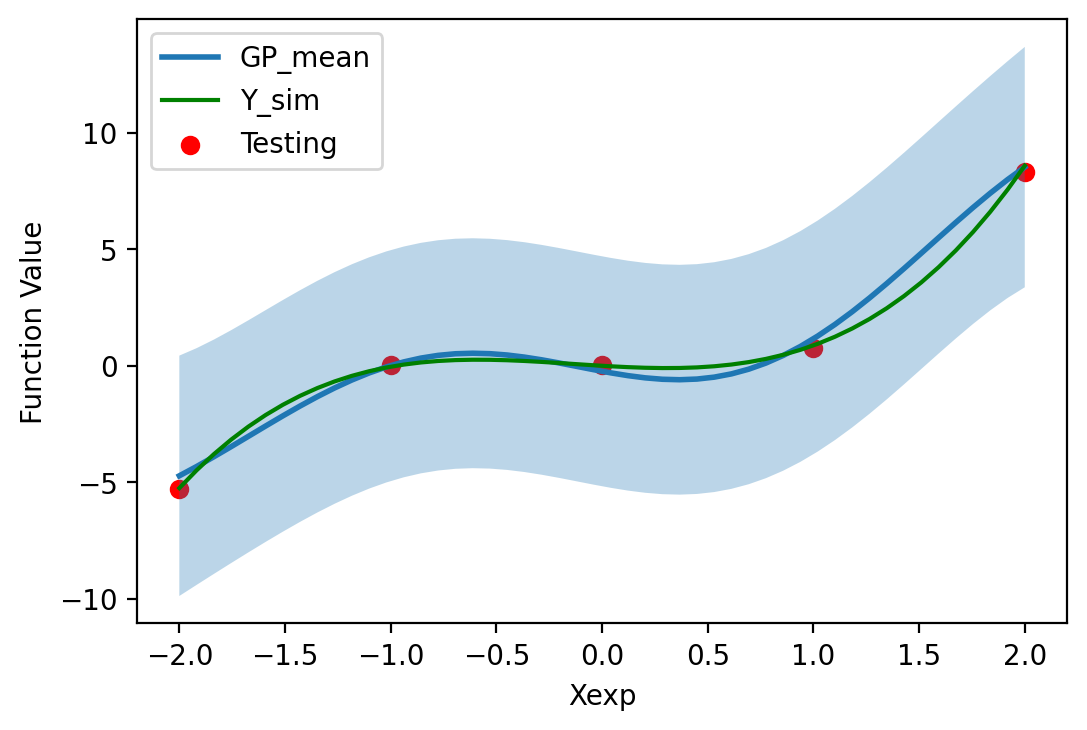

Run Number:  4


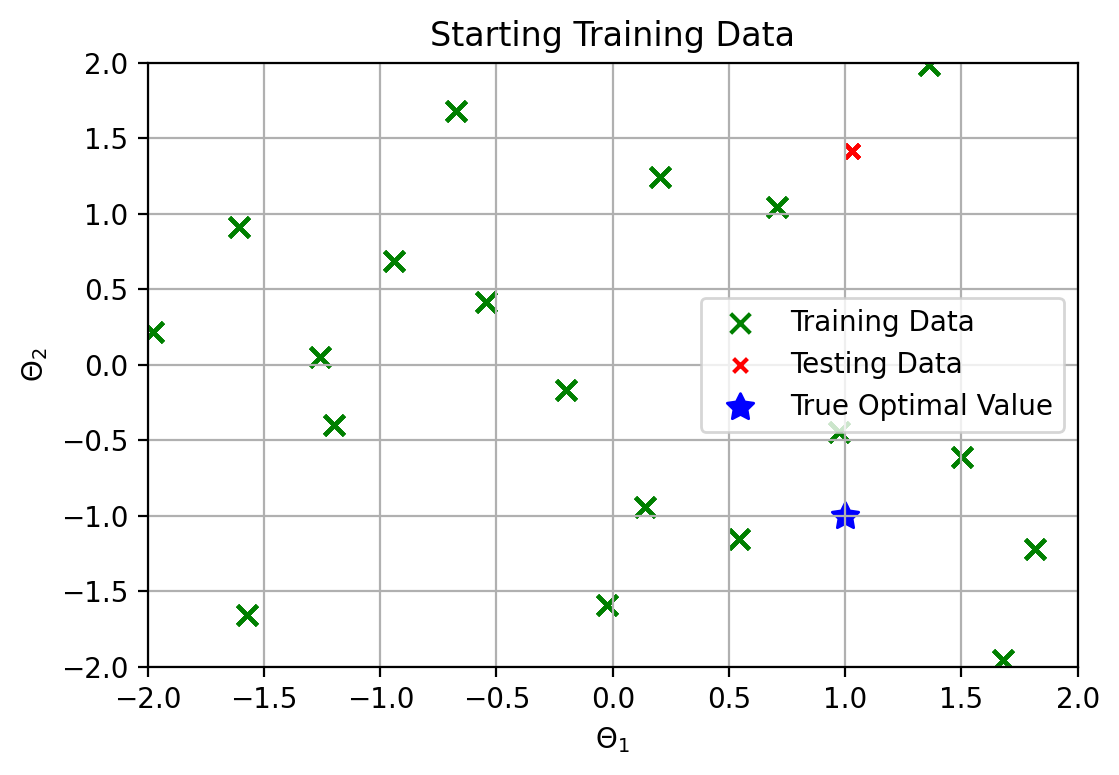

BO Iteration =  1
Showing X/Y Plot for Theta =  [1.02792127 1.41635247] with Xexp = [-2. -1.  0.  1.  2.]


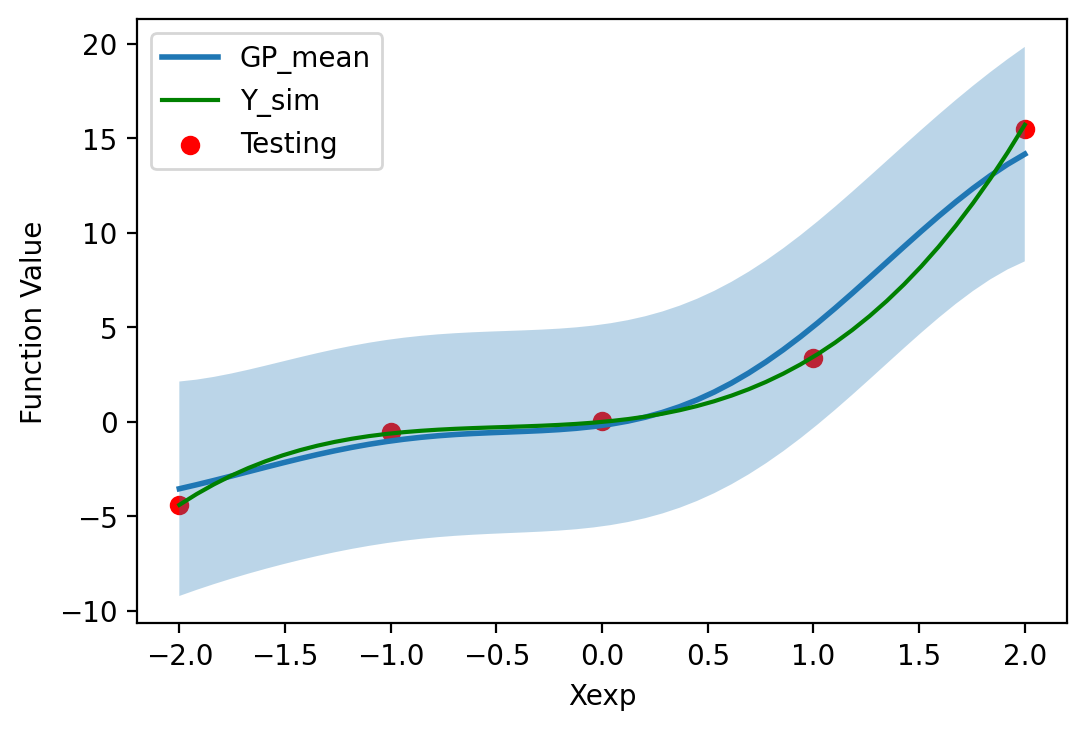

Run Number:  5


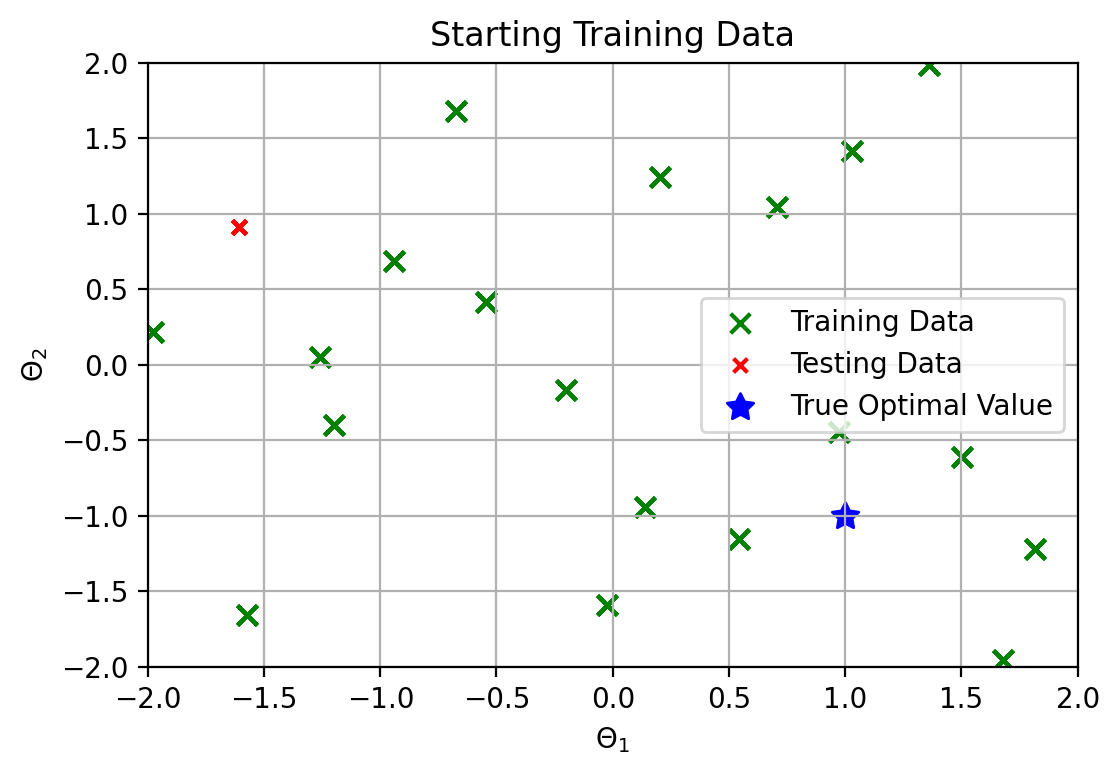

BO Iteration =  1
Showing X/Y Plot for Theta =  [-1.60531755  0.9125504 ] with Xexp = [-2. -1.  0.  1.  2.]


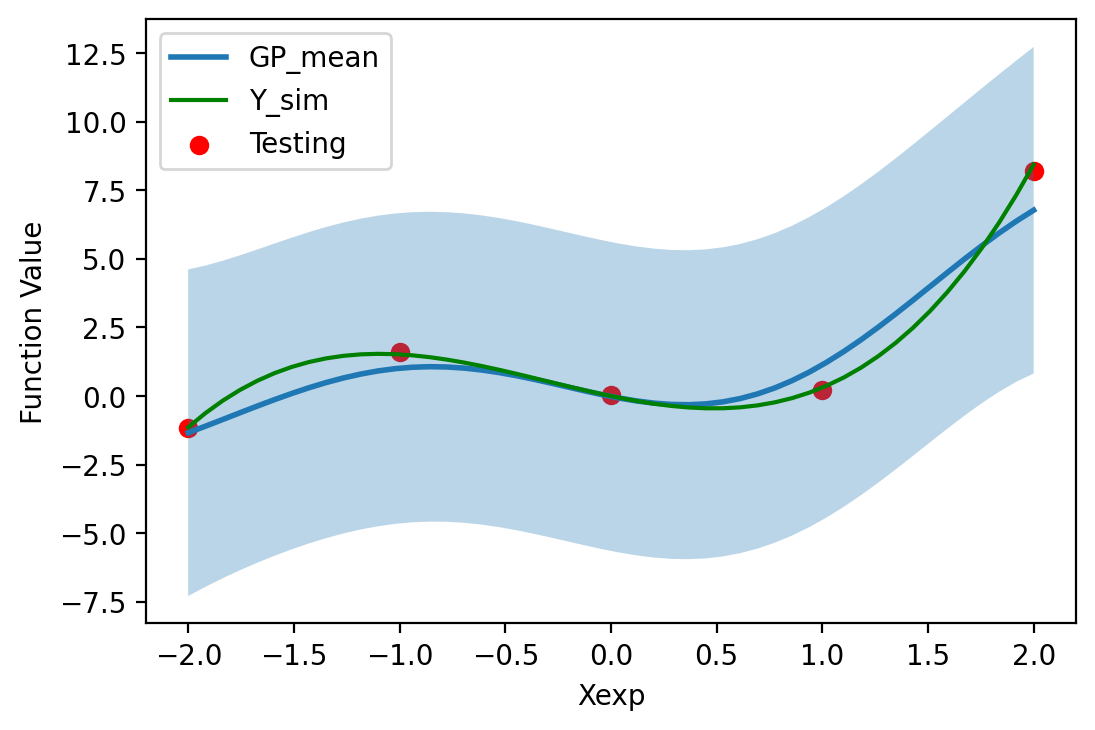

Run Number:  6


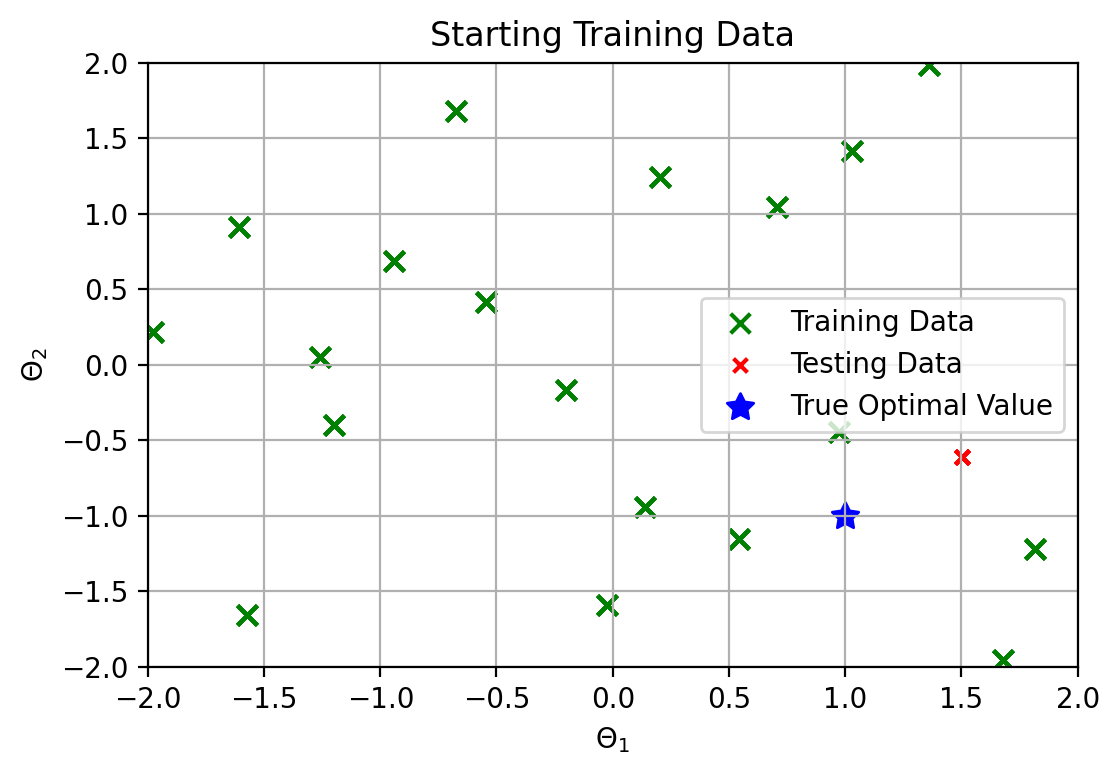

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 1.50301113 -0.61303084] with Xexp = [-2. -1.  0.  1.  2.]


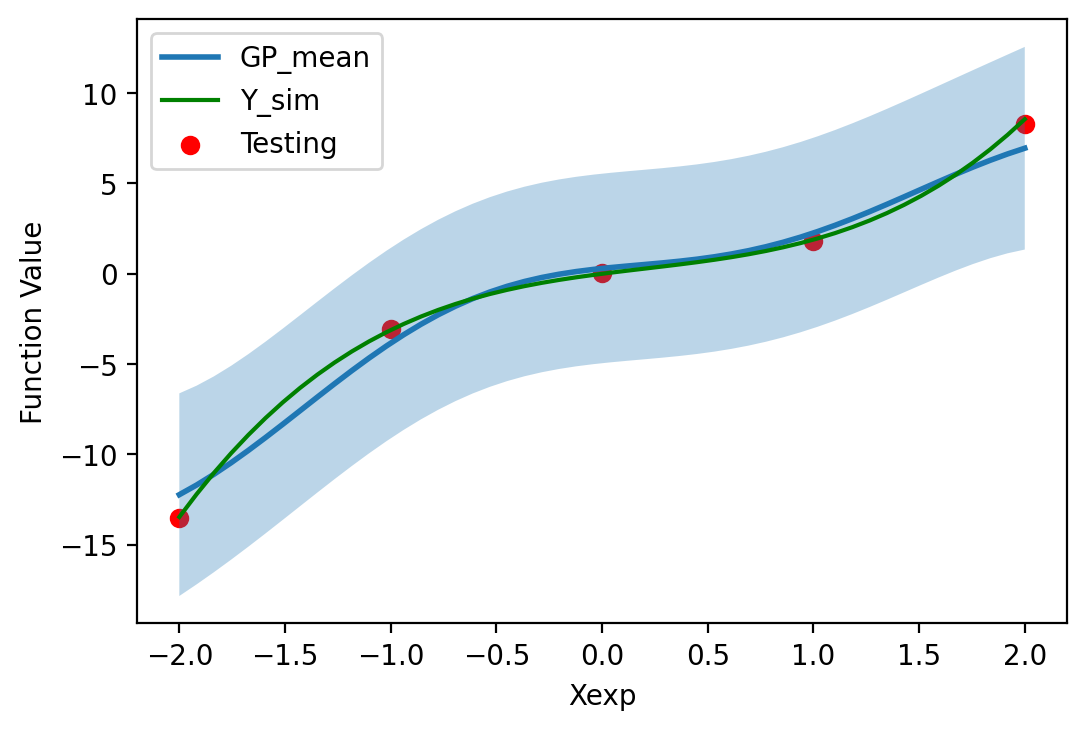

Run Number:  7


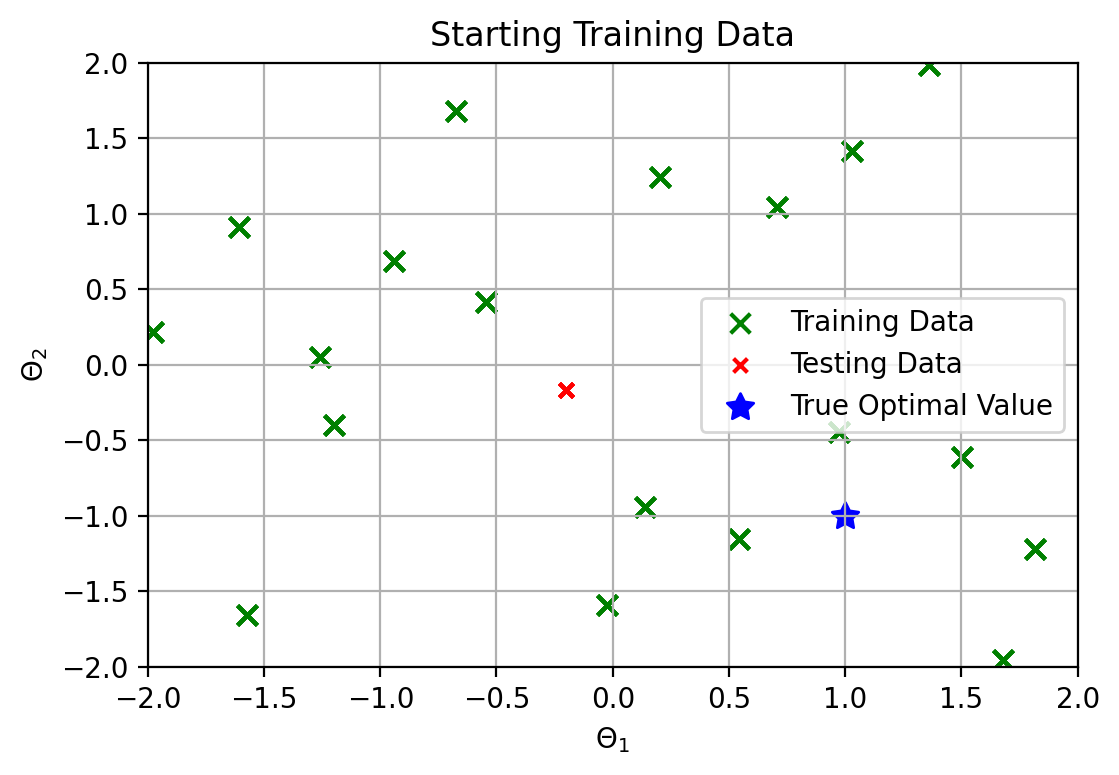

BO Iteration =  1
Showing X/Y Plot for Theta =  [-0.20112521 -0.16612429] with Xexp = [-2. -1.  0.  1.  2.]


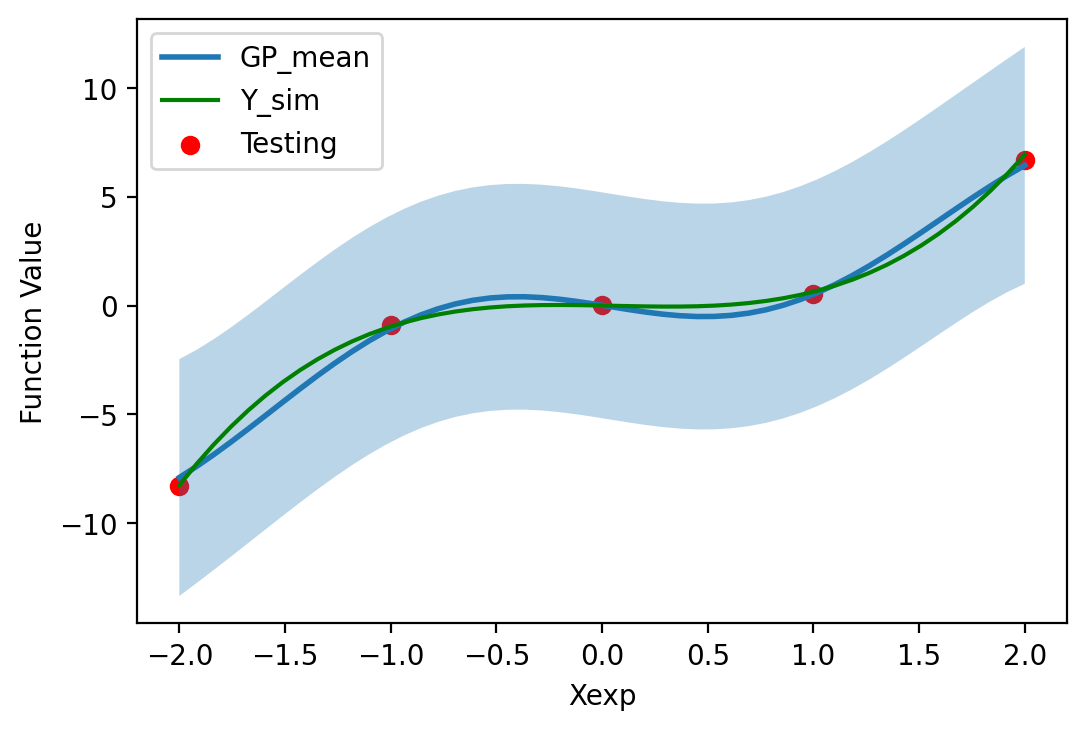

Run Number:  8


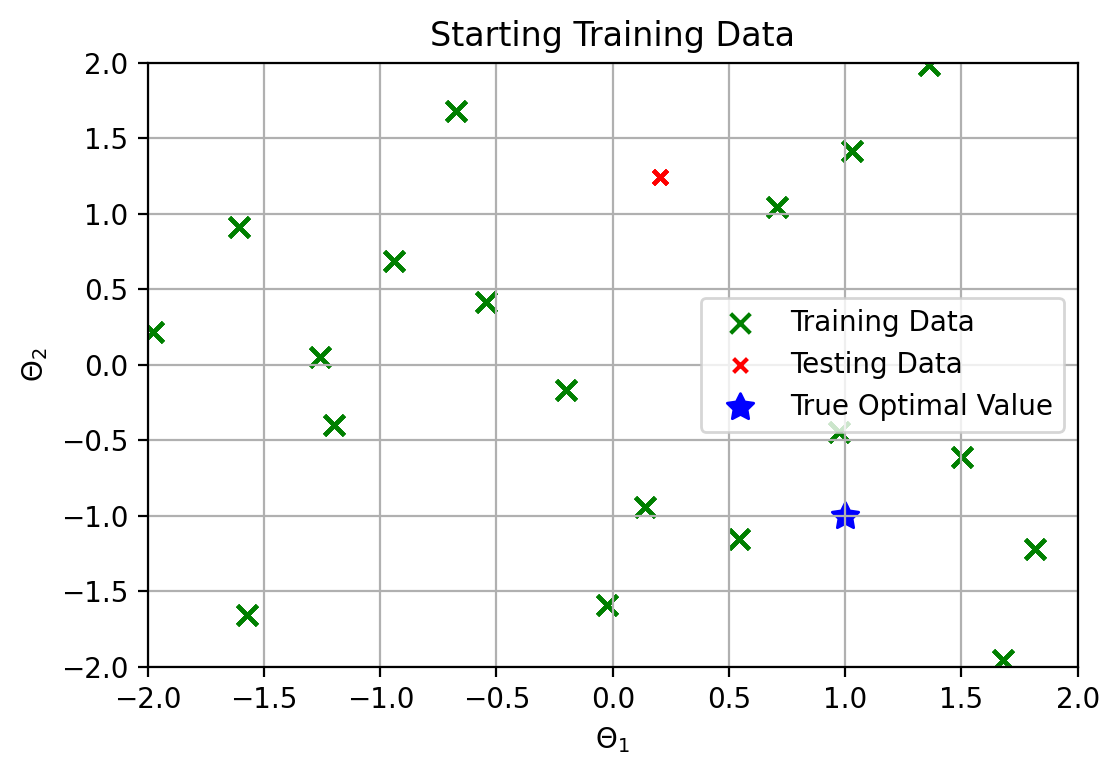

BO Iteration =  1
Showing X/Y Plot for Theta =  [0.20333955 1.24307803] with Xexp = [-2. -1.  0.  1.  2.]


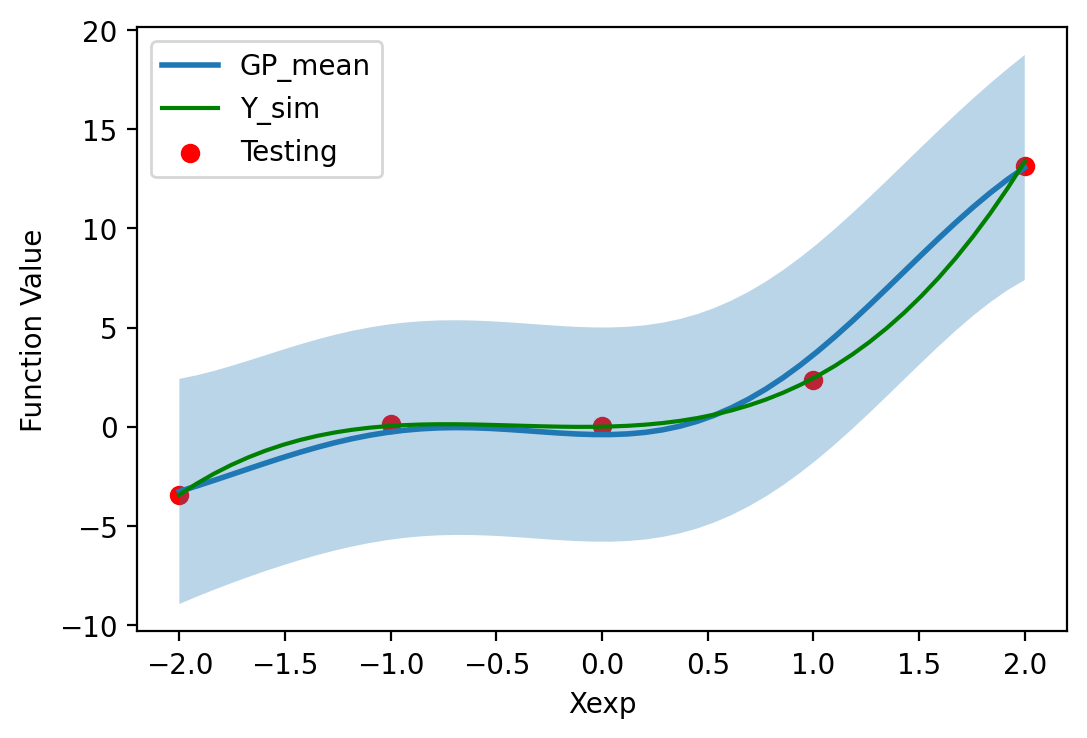

Run Number:  9


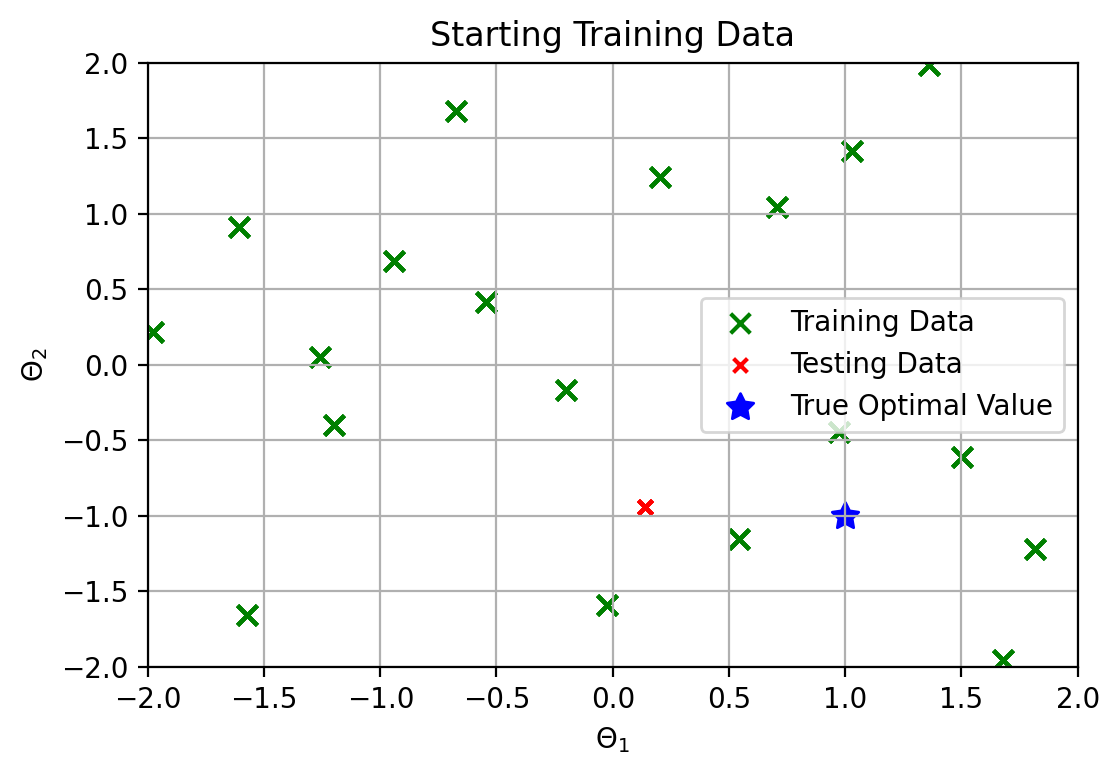

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.1368793  -0.94106674] with Xexp = [-2. -1.  0.  1.  2.]


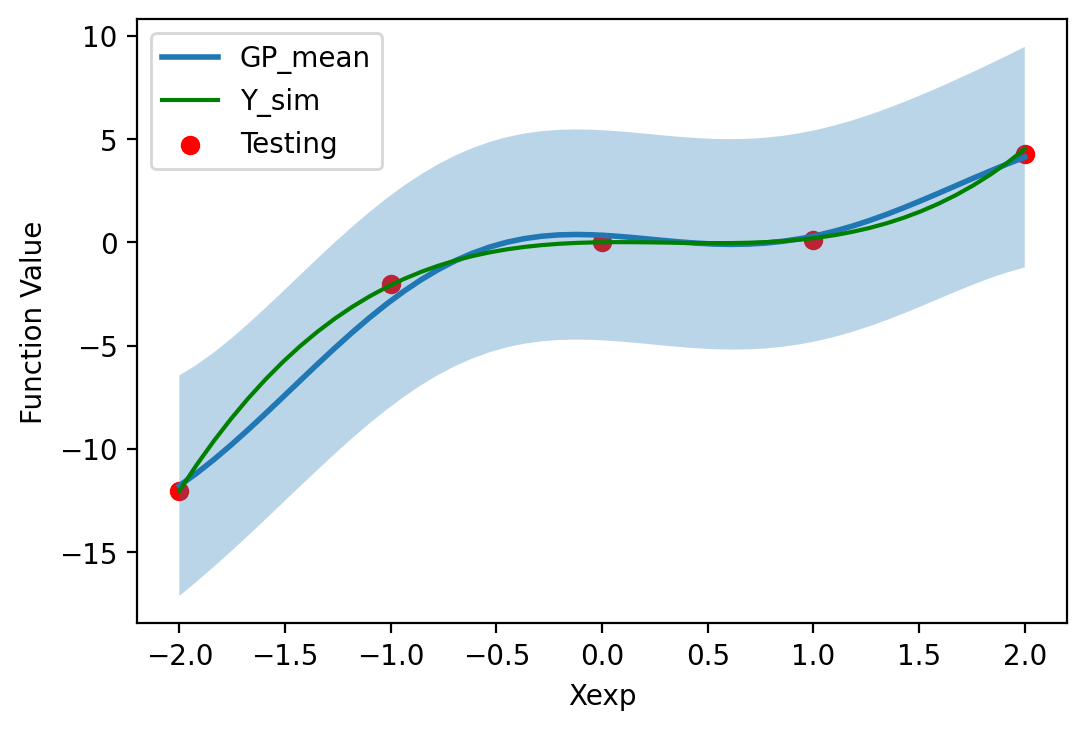

Run Number:  10


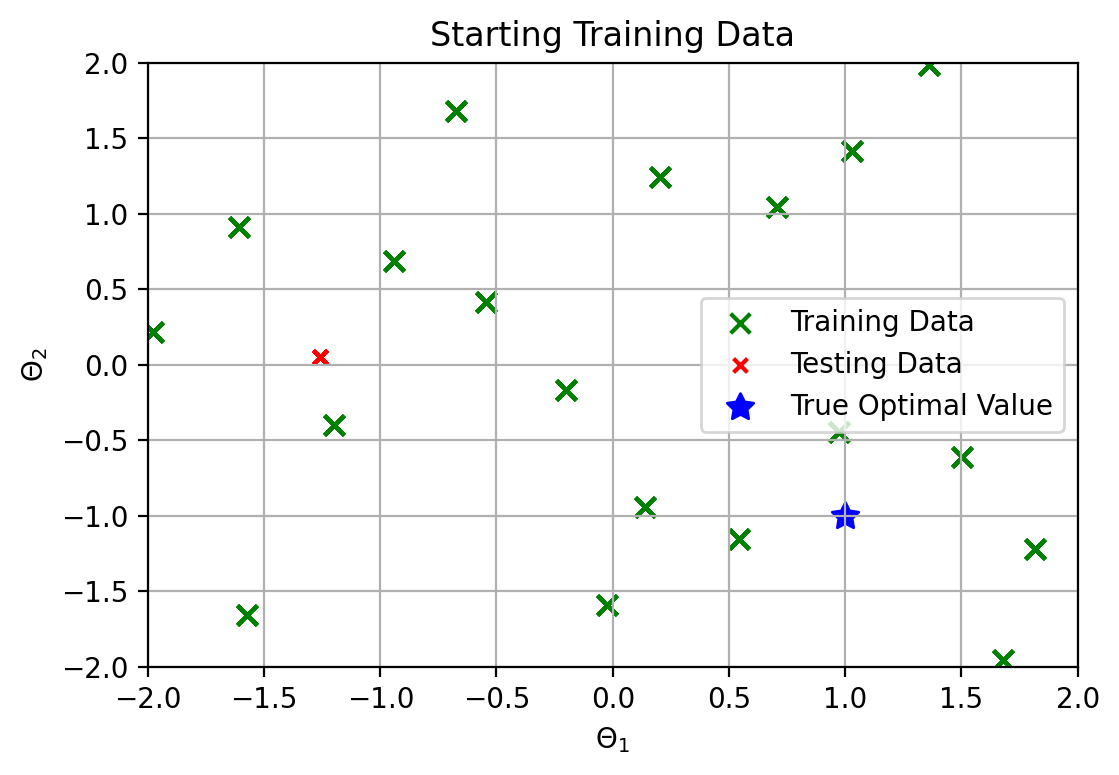

BO Iteration =  1
Showing X/Y Plot for Theta =  [-1.25983621  0.0518503 ] with Xexp = [-2. -1.  0.  1.  2.]


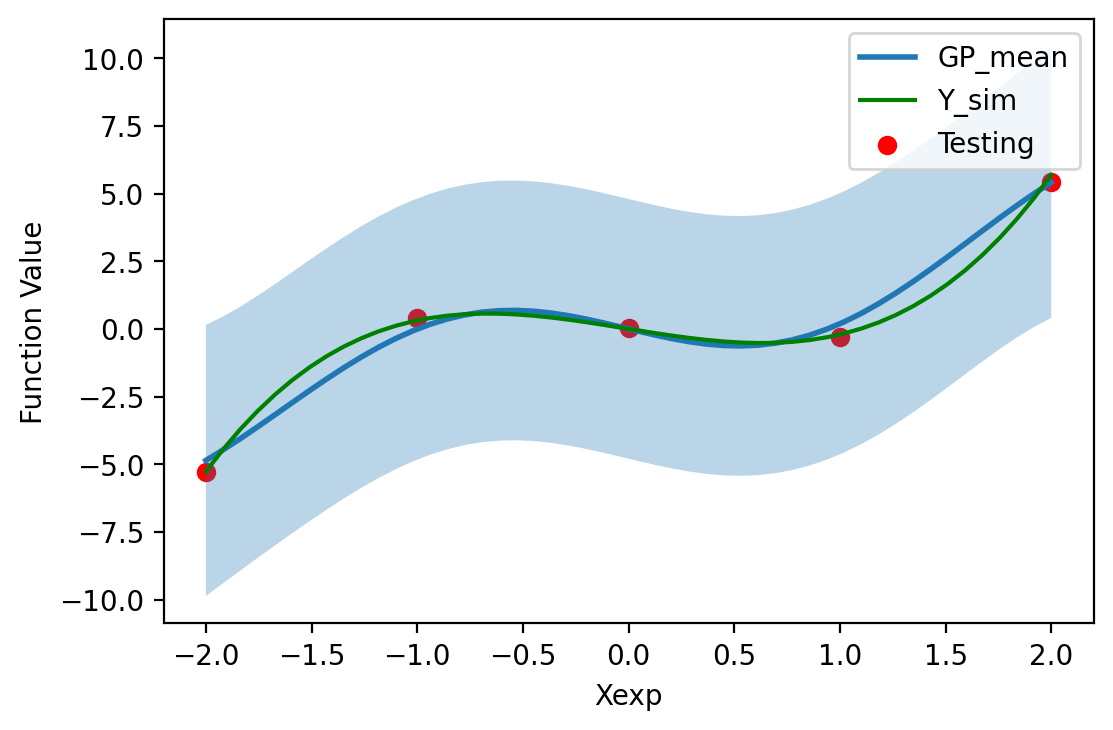

Run Number:  11


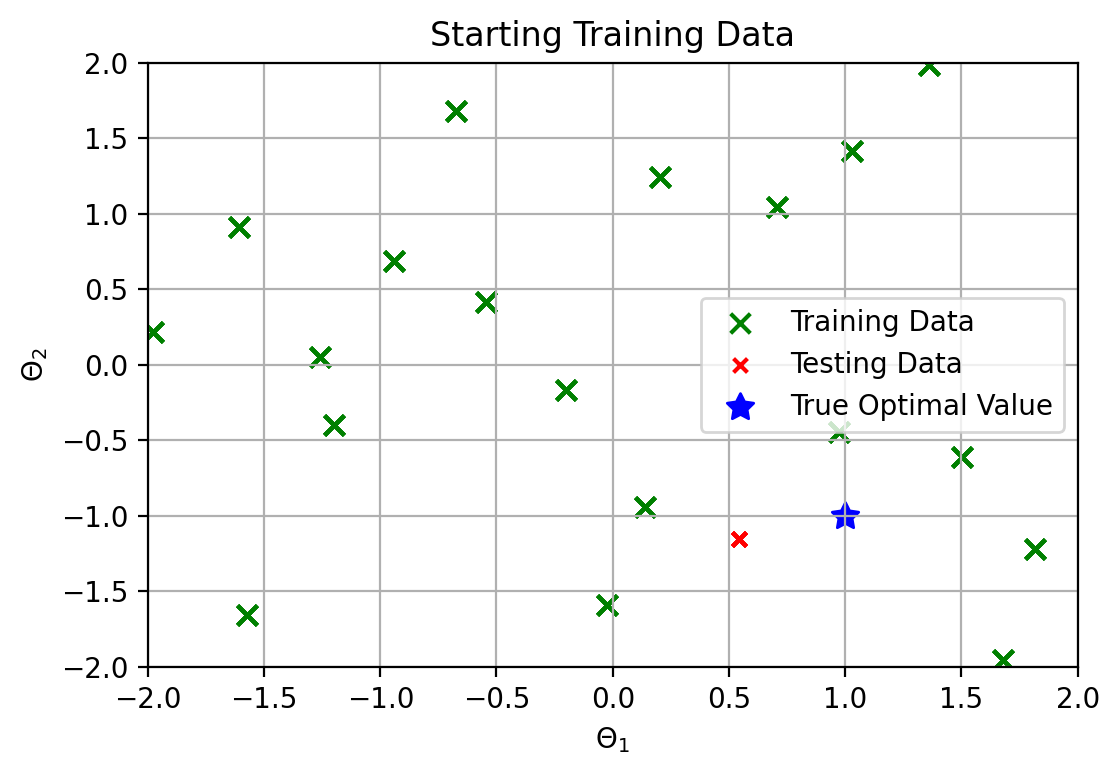

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.54405056 -1.15651818] with Xexp = [-2. -1.  0.  1.  2.]


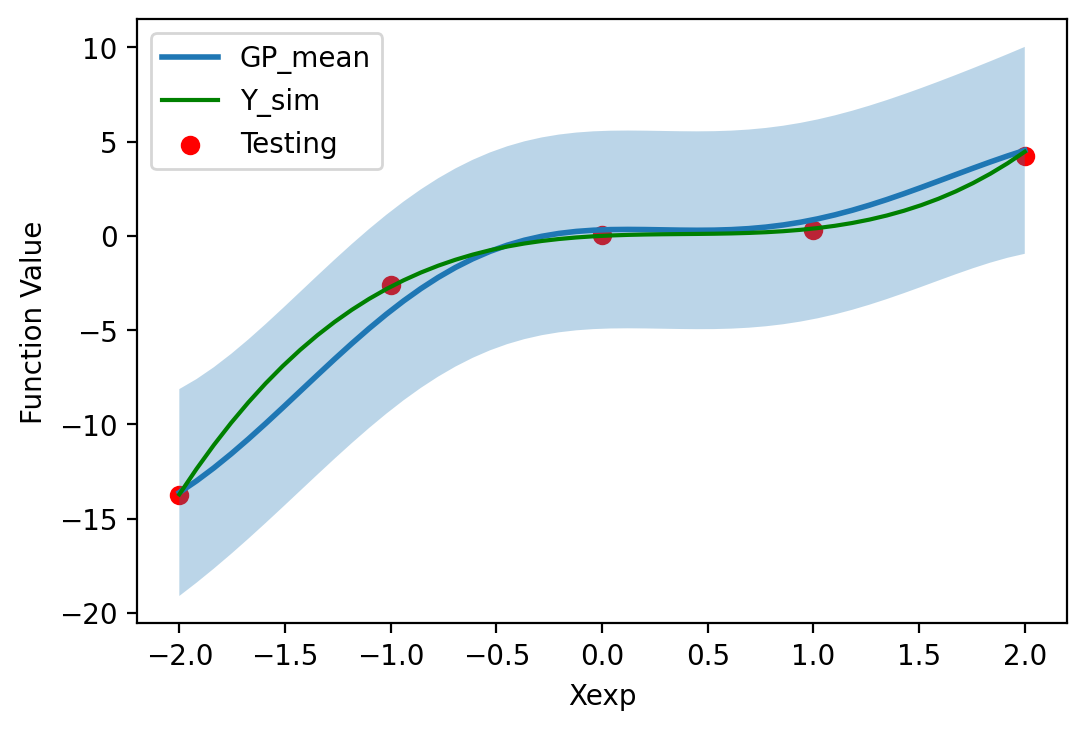

Run Number:  12


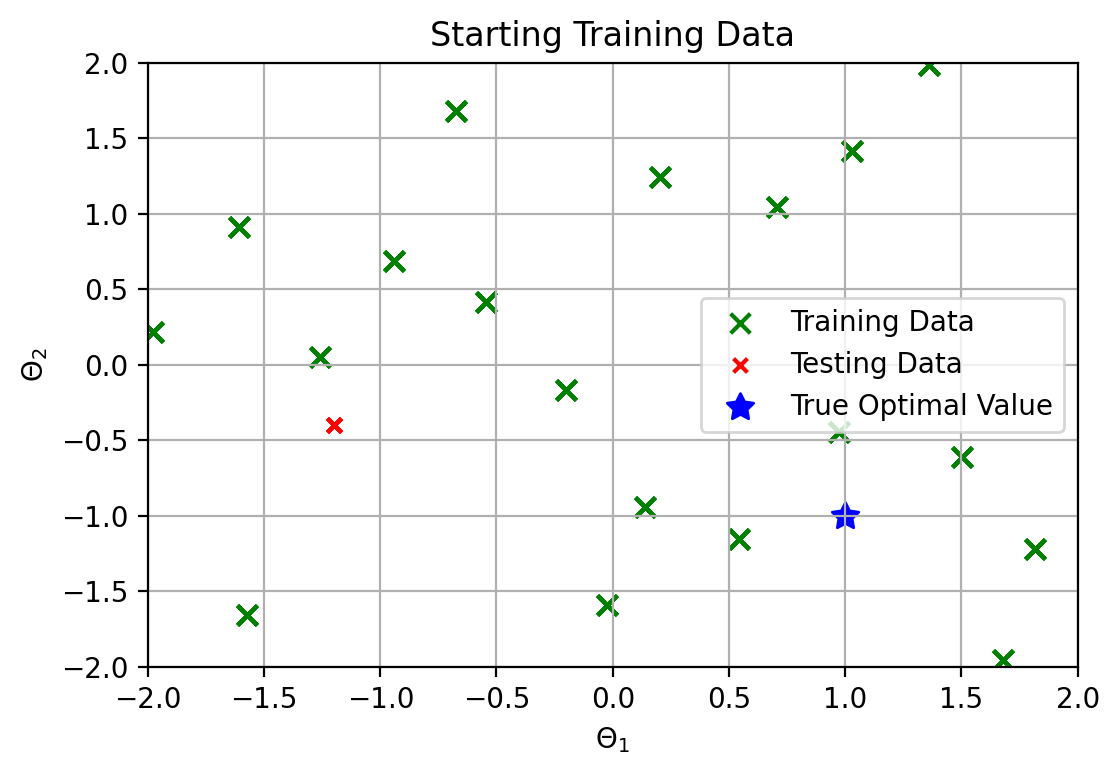

BO Iteration =  1
Showing X/Y Plot for Theta =  [-1.19754815 -0.39724771] with Xexp = [-2. -1.  0.  1.  2.]


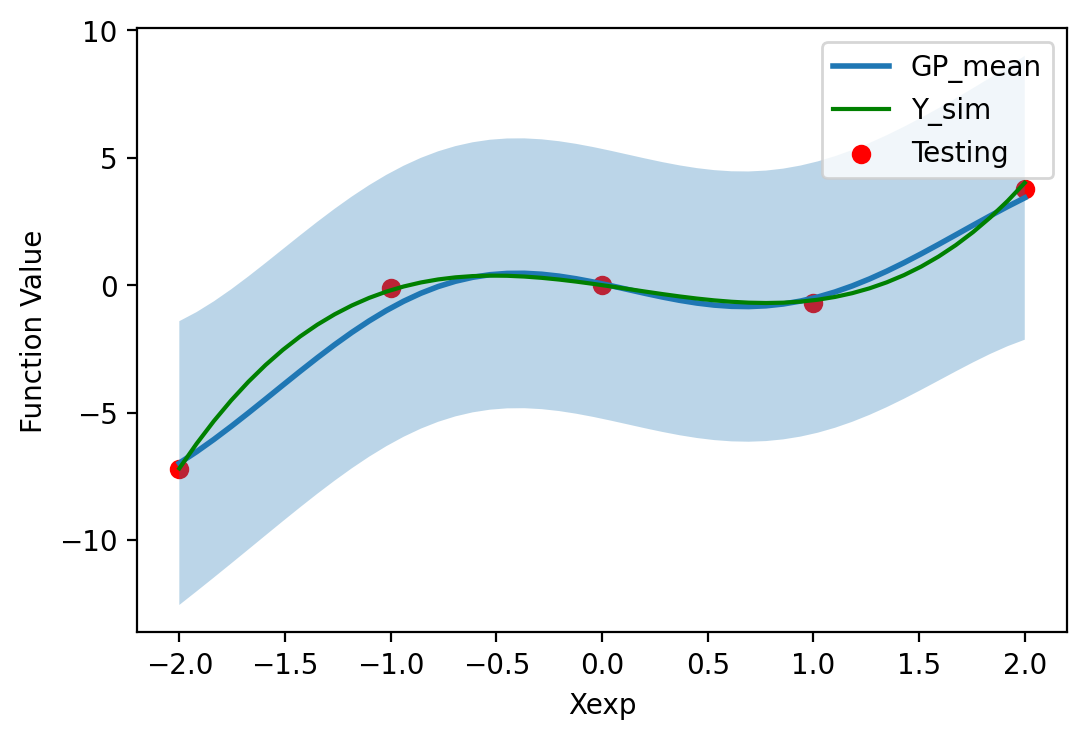

Run Number:  13


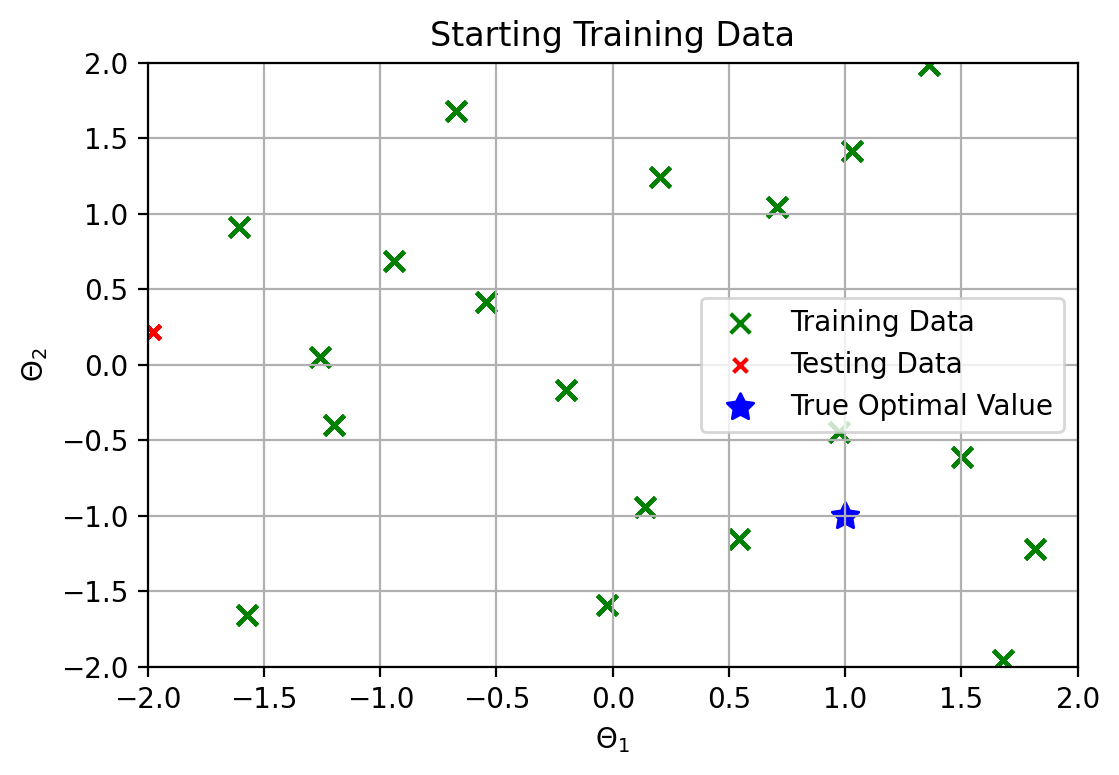

BO Iteration =  1
Showing X/Y Plot for Theta =  [-1.97657251  0.21743799] with Xexp = [-2. -1.  0.  1.  2.]


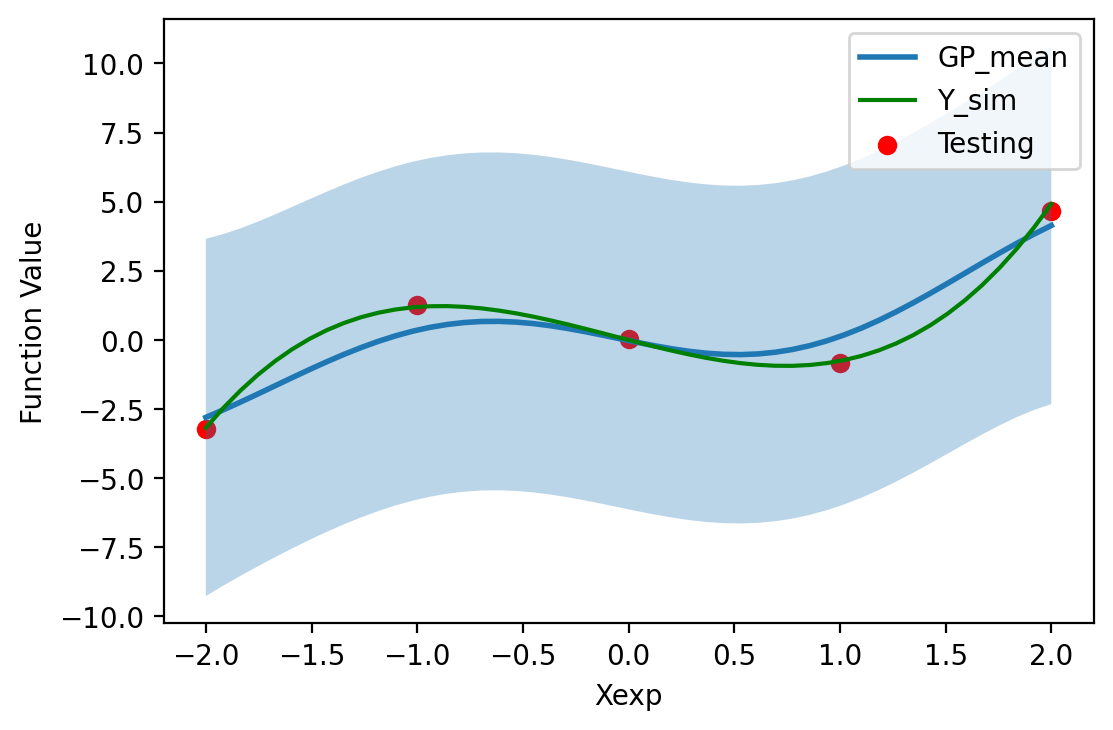

Run Number:  14


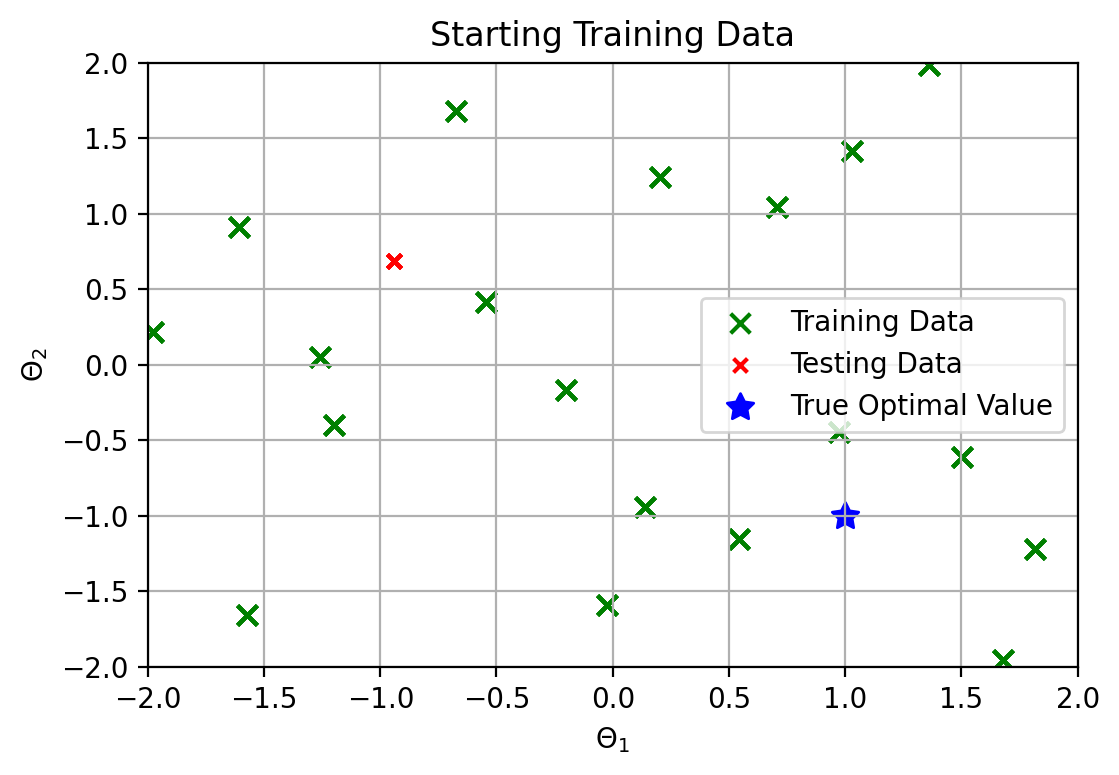

BO Iteration =  1
Showing X/Y Plot for Theta =  [-0.94164138  0.68910062] with Xexp = [-2. -1.  0.  1.  2.]


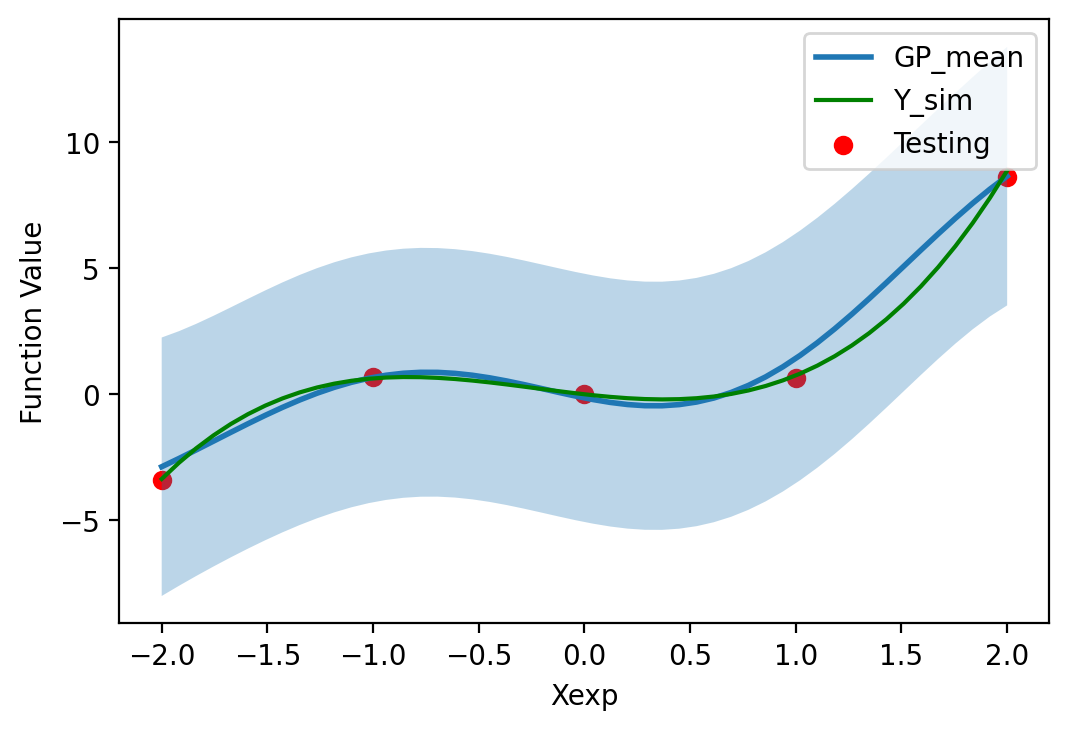

Run Number:  15


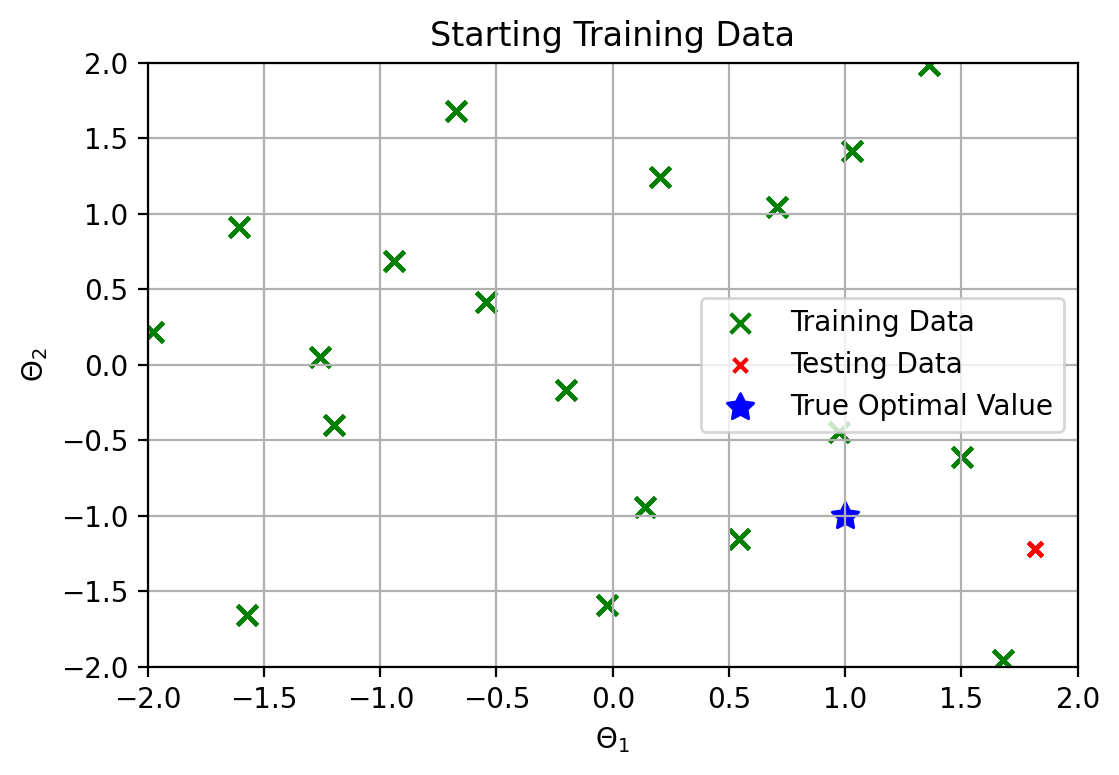

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 1.81535236 -1.21794616] with Xexp = [-2. -1.  0.  1.  2.]


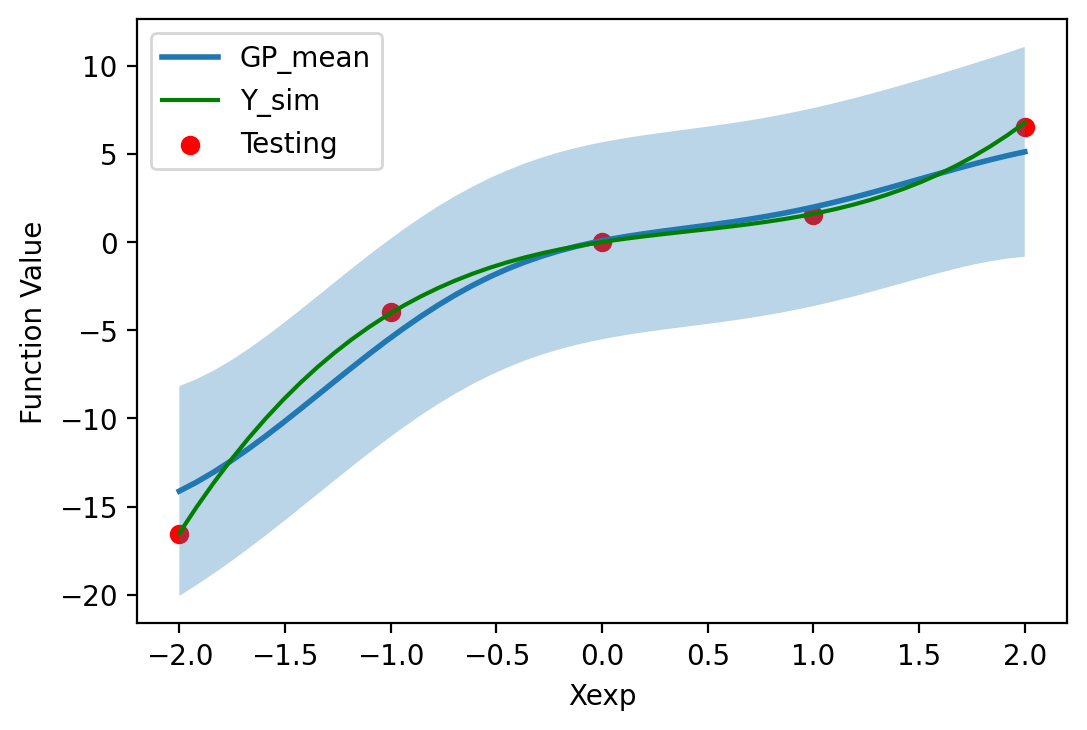

Run Number:  16


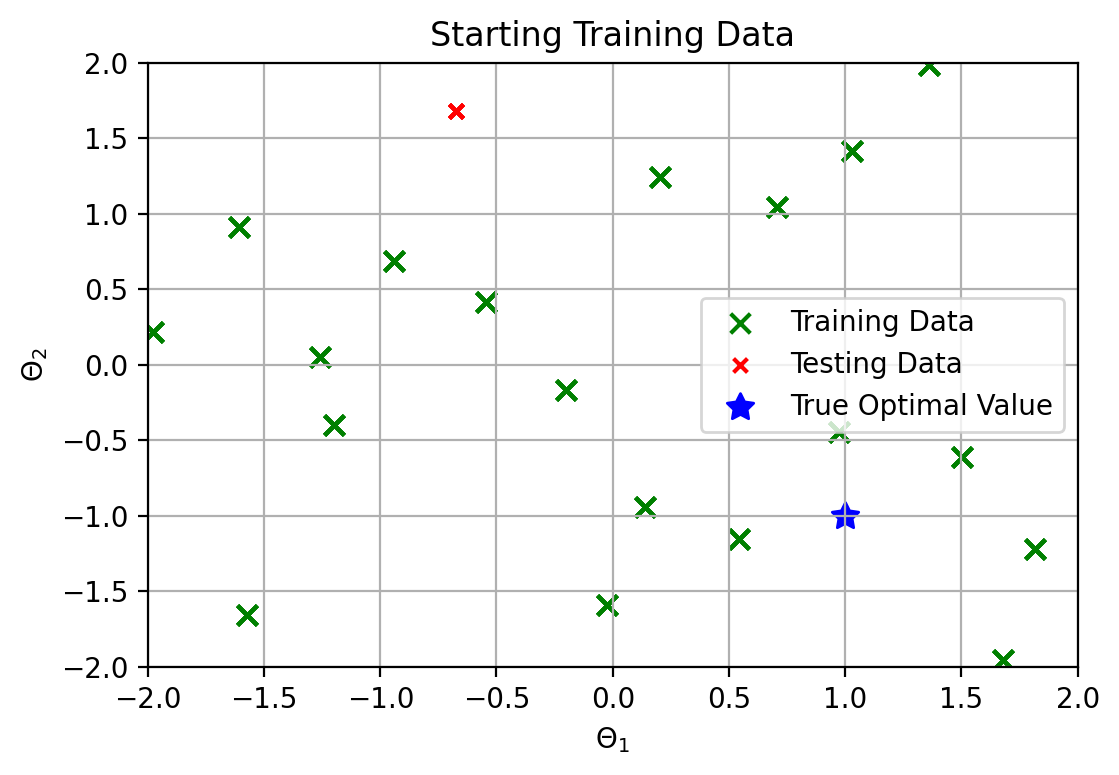

BO Iteration =  1
Showing X/Y Plot for Theta =  [-0.67402631  1.67881221] with Xexp = [-2. -1.  0.  1.  2.]


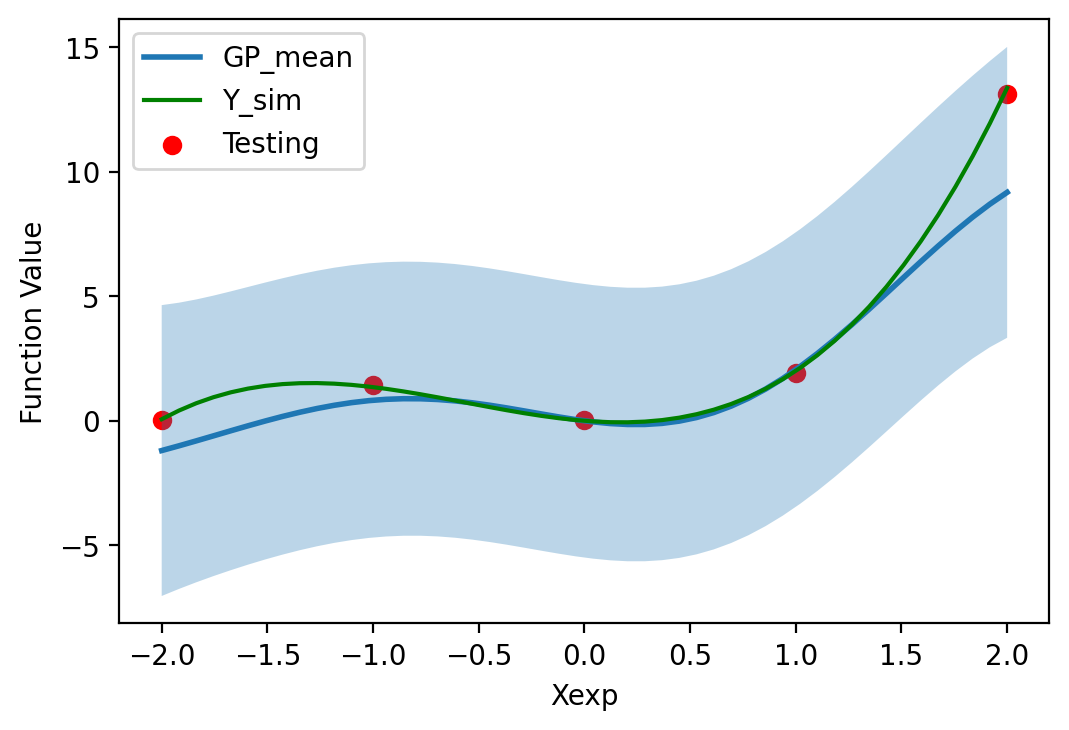

Run Number:  17


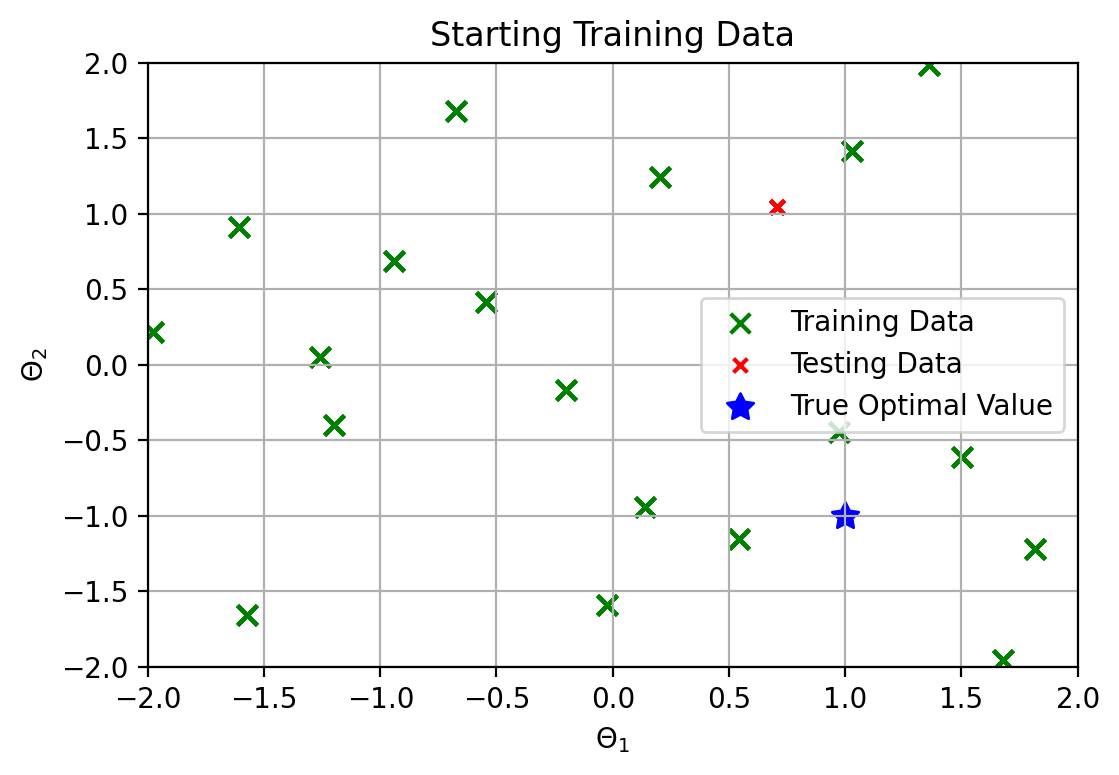

BO Iteration =  1
Showing X/Y Plot for Theta =  [0.70445402 1.04142842] with Xexp = [-2. -1.  0.  1.  2.]


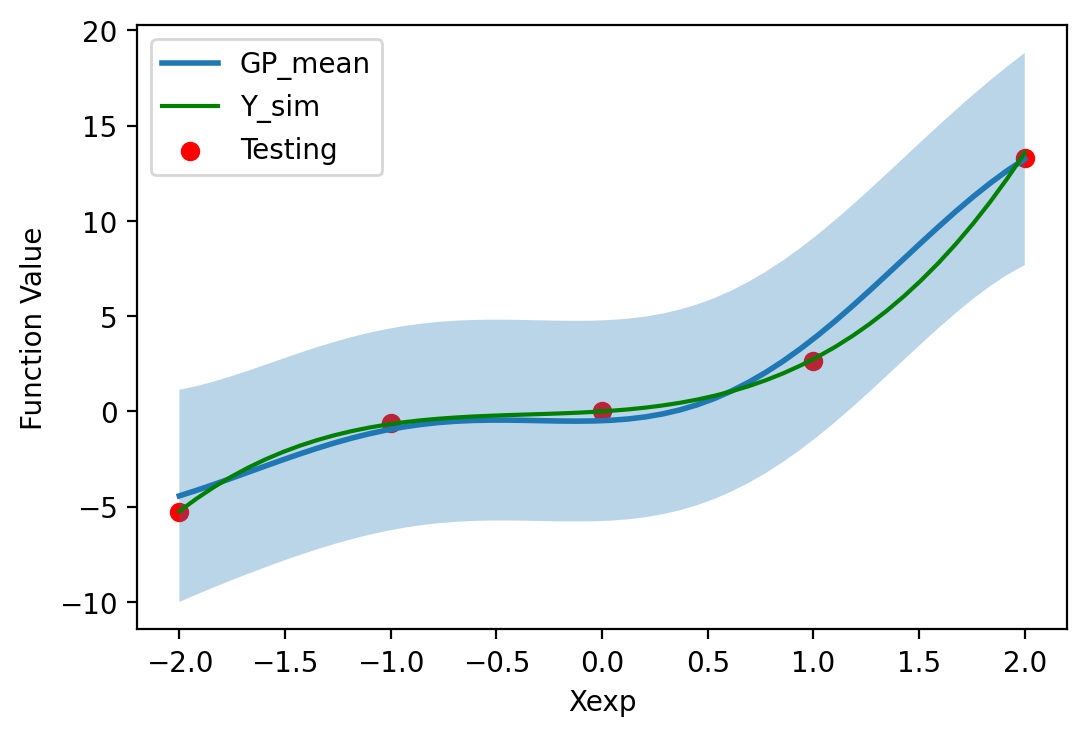

Run Number:  18


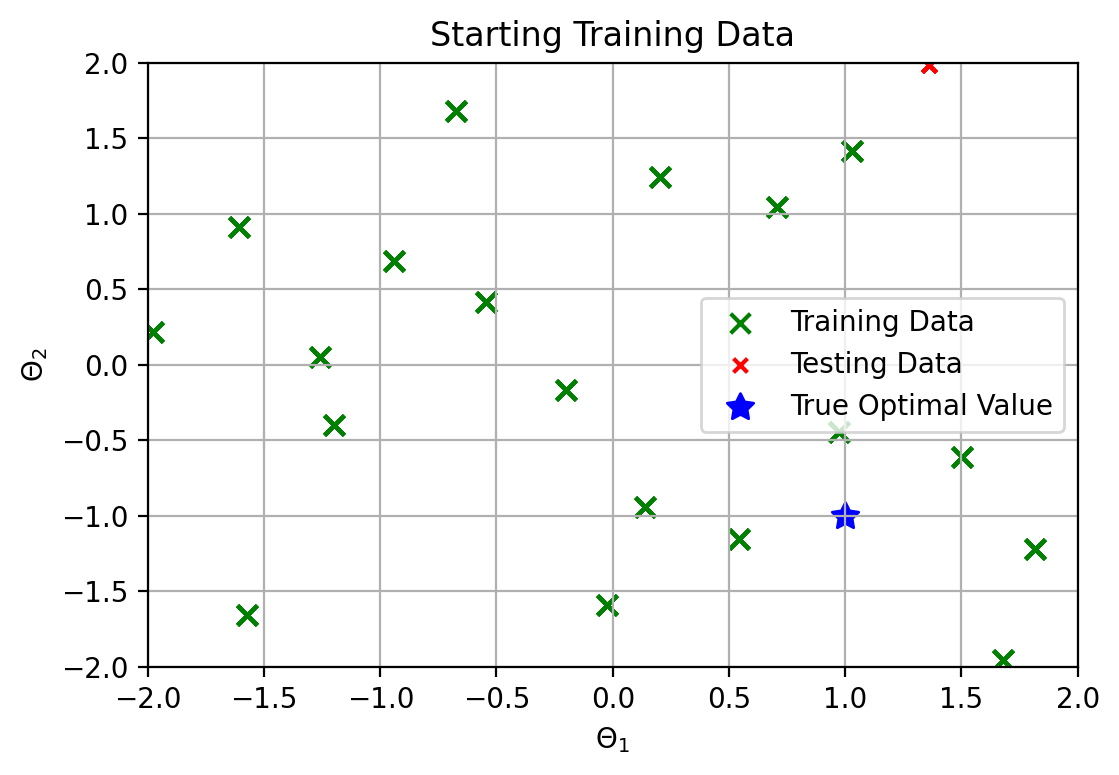

BO Iteration =  1
Showing X/Y Plot for Theta =  [1.36098272 1.9875493 ] with Xexp = [-2. -1.  0.  1.  2.]


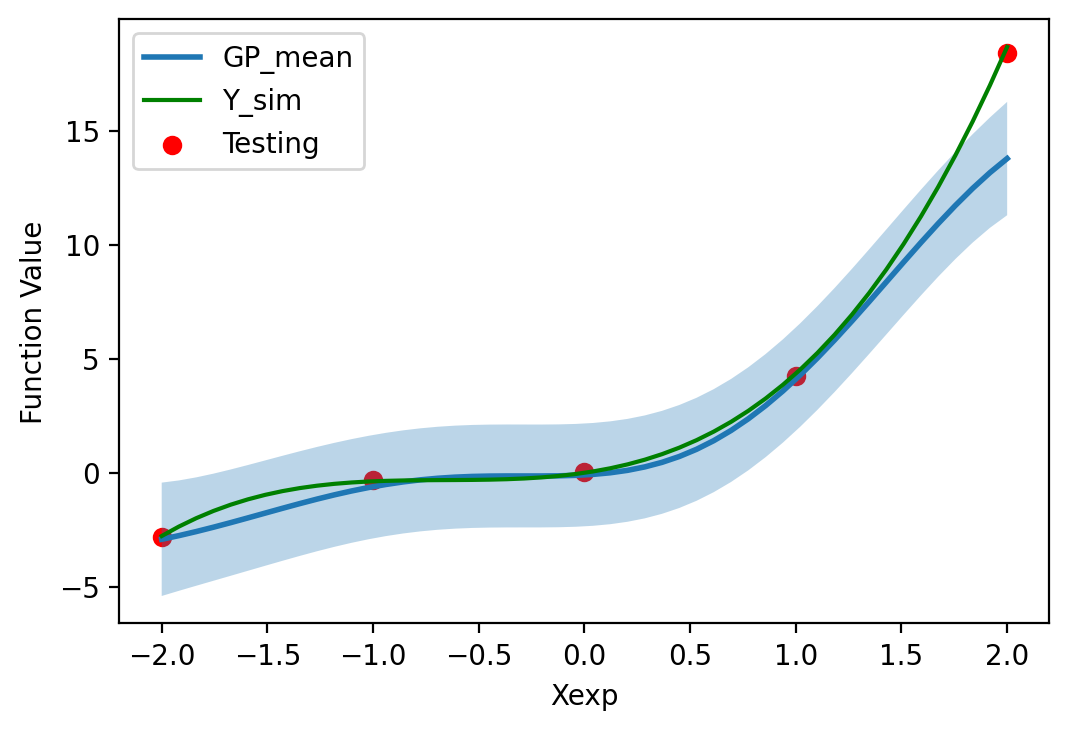

Run Number:  19


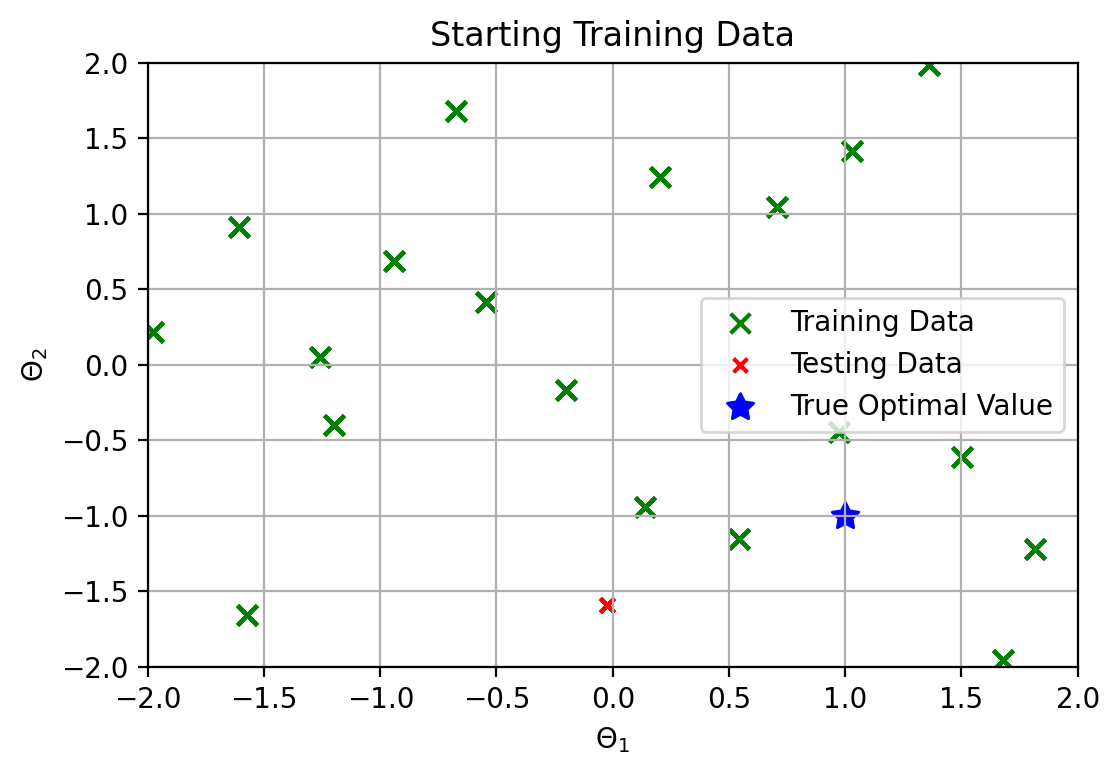

BO Iteration =  1
Showing X/Y Plot for Theta =  [-0.02530368 -1.59255632] with Xexp = [-2. -1.  0.  1.  2.]


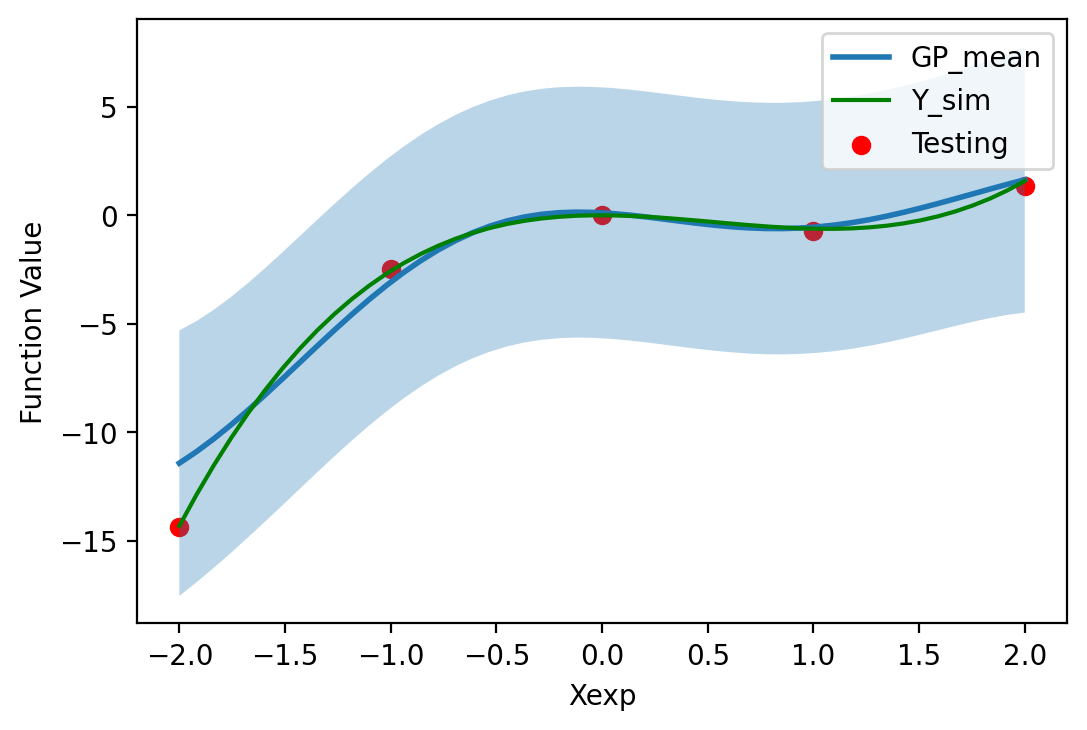

Run Number:  20


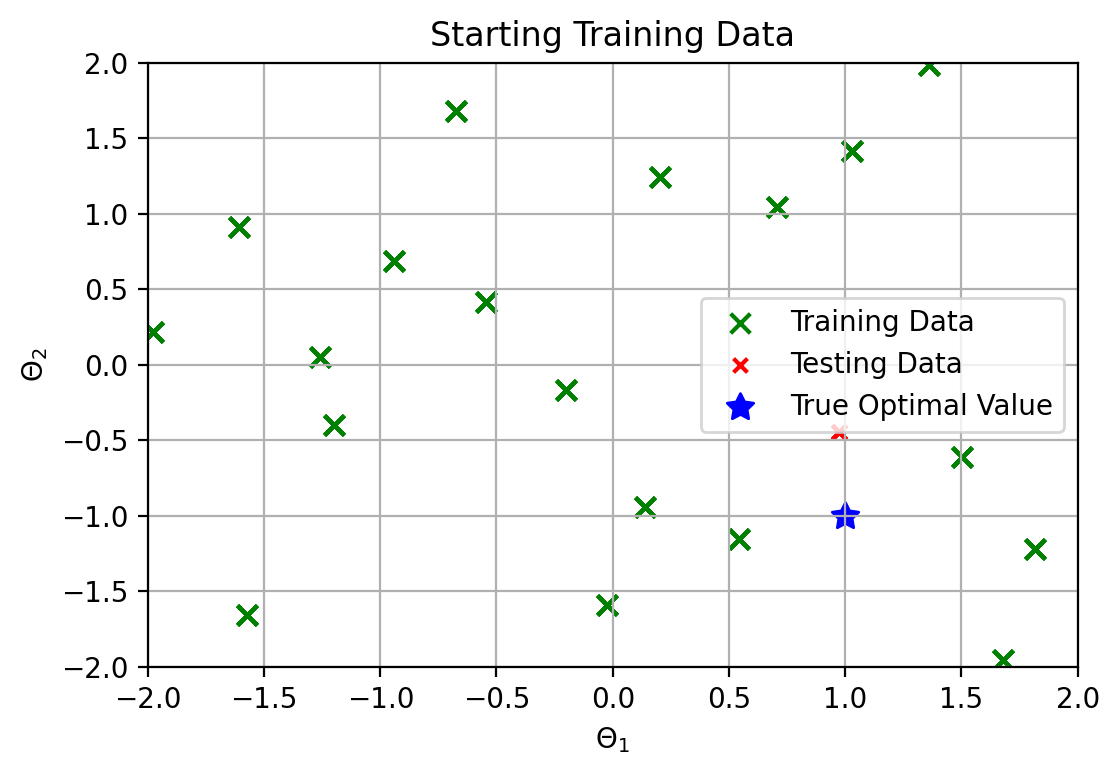

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.97344509 -0.44521967] with Xexp = [-2. -1.  0.  1.  2.]


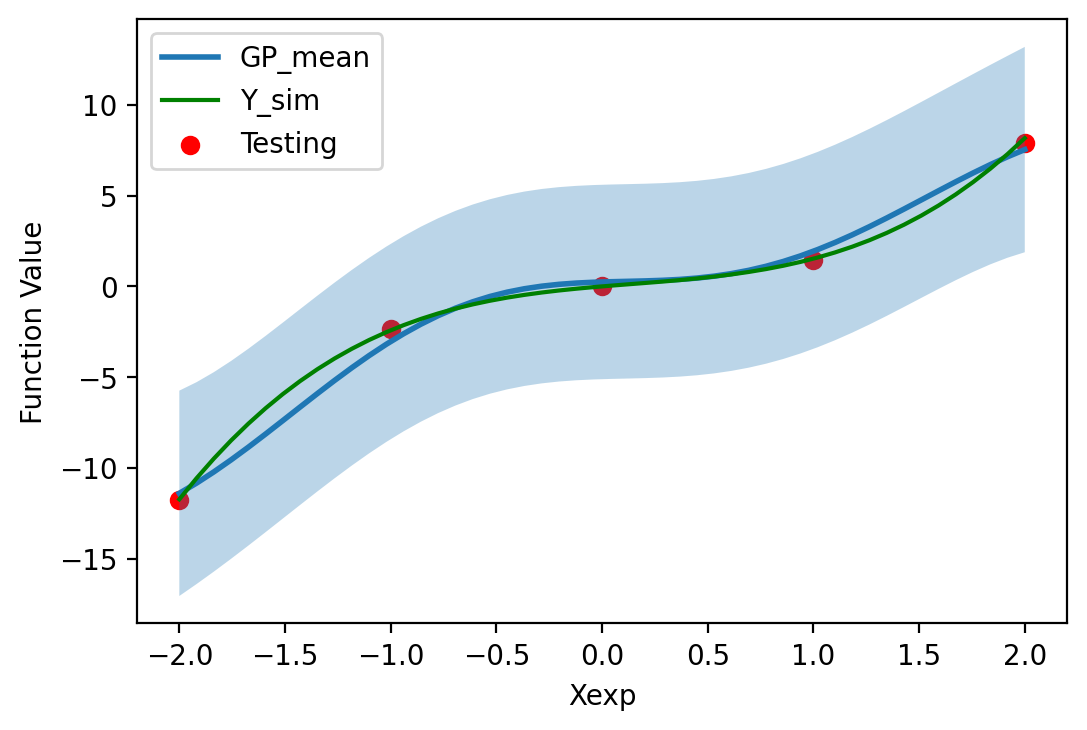

CPU times: user 1min 57s, sys: 427 ms, total: 1min 57s
Wall time: 1min 58s


In [3]:
%%time
obj = "obj"

all_data_doc = "Input_CSVs/Train_Data/all_3_data/t=100.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

t = len(all_data)

print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")

print("Lengthscale Set To:", set_lengthscale)
print("Explore Bias:", str(np.round(float(explore_bias[0]),3)))
results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[0], Xexp, Yexp,
                                 noise_std, obj, runs, sparse_grid, emulator, set_lengthscale, verbose, 
                                 save_fig, shuffle_seed, DateTime)